# Getting Started with CyberGISX
### Prepared for AAG 2023 Workshop by [Jinwoo Park](https://jparkgeo.github.io)

# General information about Jupyter Notebook/Lab

- **Cell**
    - Add a cell: single click on a cell --> click plus icon (+) above. 
    - Delete a cell: single click on the cell to delete --> Menu --> Edit --> Delete Cells 
    - Reorder a cell: drag cell with mouse
    - Change cell type: click the dropdown list above. 
    - Edit cell
        - Markdown: double click   ([basic syntax reference](https://jupyter-notebook.readthedocs.io/en/stable/examples/Notebook/Working%20With%20Markdown%20Cells.html))
        - Code: single click  
    - Run a cell: single click on a cell --> click play button above (or Shift + Enter).
    - Run all cells: Menu --> Run --> Run All Cells.
    - Clear all cell output: Menu --> Edit --> Clear All Outputs
<br><br>
- **Kernel**
    - Change kernel: Menu --> Kernel --> Change kernel
    - Choose versioned kernel (eg XXXXX-0.8.0) before sharing
    - Restart kernel: Menu --> Kernel --> Restart (& Clear output)
<br><br>    
- **Troubleshooting**
    - Restart kernel: Menu --> Kernel --> Restart Kernel
    - Restart CyberGIS-Jupyter (save notebook first!): Menu --> File --> Hub Control Panel --> Stop My Server --> Start Server
<br><br>    
- **More Info**
    - ["Getting Started" series notebooks on CyberGISX](https://cybergisxhub.cigi.illinois.edu/notebooks/)
    - ["Jupyter Notbooks" section in Knowledge Base](https://cybergisxhub.cigi.illinois.edu/knowledge-base/)
    - [Announcement area](https://cybergisxhub.cigi.illinois.edu/release-notes/)
    - [Library List](https://cybergisxhub.cigi.illinois.edu/current-library-list/)

---
### *Exercise* (3 minutes)

**Task 1**: Add one new code cell after this cell. <br>
*Hint*: Single click on a cell --> click plus icon (+) above. 

**Task 2**: Change the new cell's type to Markdown, and write something in it. <br>
*Hint*: Click the dropdown list above; Single click on the new cell ---> write some Markdowns see [basic syntax reference](https://jupyter-notebook.readthedocs.io/en/stable/examples/Notebook/Working%20With%20Markdown%20Cells.html); Click on the "Run" button on the tool bar.

**Task 3**: Uncomment the Python codes in the cell  below and run it. <br>
*Hint*: Single click on the cell below --> Remove the Pound sign ('#') OR <br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Press Shift + Enter keys together (or click on the 'Run" button on the tool bar)

**Task 4**: clean all output of this notebook. <br>
*Hint*: Go to Menu --> Edit --> Clear All Outputs

---

In [1]:
# Task 2: Chage this cell to Markdown

In [2]:
'''
Task 3: Uncomment the code below. 
'''
# print("Hello World")

'\nTask 3: Uncomment the code below. \n'

# Examining Social Vulnerability Index (SVI) in the Conterminous US

## Introduction

This notebook will walk you through some basic techniques for **spatial analysis and visualization** in the CyberGIS-Jupyter environment. We will use CDC county-level Social Vulnerability Index (SVI) data to examine the characteristics of SVI and whether they are spatially autocorrelated. 

Specifically, this notebook includes functions for <br>
1. Changing coordinate systems, 
2. Creating Choropleth maps, and 
3. Conducting Moran's I and Local Indicators of Spatial Association (LISA). 

### What is Social Vulnerability?

The degree to which a community exhibits **certain social conditions, including high poverty, low percentage of vehicle access, or crowded households**, may affect that community’s ability to prevent human suffering and financial loss in the event of disaster (e.g., a tornado, disease outbreak, or a chemical spill). These factors describe a community’s social vulnerability. <br><br>

<img src="https://www.atsdr.cdc.gov/placeandhealth/svi/documentation/SVI-Variables.png?_=02699" width="750" align="center">

Source: https://www.atsdr.cdc.gov/placeandhealth/svi/documentation/SVI_documentation_2020.html


### Setup
This cell is to import required modules and libs. A breif description on the purpose of each libs can be found below:

 - [pandas](https://pandas.pydata.org/): for tabular data analysis and manipulation
 - [geopandas](https://geopandas.org/en/stable/): extention of pandas with **spatial information** 
 - [PySAL](https://pysal.org/): Python Spatial Analysis Library for open source, cross platform Geospatia Data Science
     - [libpysal](https://pysal.org/libpysal/): Core package
     - [esda](https://pysal.org/esda/index.html): Exploratory Spatial Data Analysis (e.g., Moran's I)
     - [mapclassify](https://pysal.org/mapclassify/): Choropleth map classification
 - [matplotlib](https://matplotlib.org/) - for creating plots and figures 

In [3]:
import geopandas as gpd
import pandas as pd
import libpysal
import esda
import mapclassify
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

import warnings
warnings.filterwarnings('ignore')

## Data Preprocessing

In [4]:
# Social Vulnerability per county
# Data source: https://www.atsdr.cdc.gov/placeandhealth/svi/data_documentation_download.html

# Read Shapefile into GeoDataFrame
county_svi = gpd.read_file('./data/SVI2020_US_county.shp')

# The original data has numerous columns, so we only select the necessary information
county_svi = county_svi[['ST', 'STATE', 'ST_ABBR', 'COUNTY', 'FIPS', 'SPL_THEMES' , 'geometry']]

# Call the first 5 rows of GeoDataFrame
county_svi.head()

ST    STATE ST_ABBR   COUNTY   FIPS  SPL_THEMES  \
0  01  Alabama      AL  Autauga  01001      8.0255   
1  01  Alabama      AL  Baldwin  01003      6.8498   
2  01  Alabama      AL  Barbour  01005     12.2801   
3  01  Alabama      AL     Bibb  01007      9.8077   
4  01  Alabama      AL   Blount  01009      8.0278   

                                            geometry  
0  POLYGON ((-86.92120 32.65754, -86.92035 32.658...  
1  POLYGON ((-88.02858 30.22676, -88.02399 30.230...  
2  POLYGON ((-85.74803 31.61918, -85.74543 31.618...  
3  POLYGON ((-87.42194 33.00338, -87.31854 33.006...  
4  POLYGON ((-86.96336 33.85822, -86.95967 33.857...

In [5]:
# A CSV file that defines which states in the conterminous US

# Read CSV file into DataFrame
lookup = pd.read_csv('./data/state_lookup.csv')

# Select only necessary information
lookup['ST_ABBR'] = lookup['Abbr']
lookup = lookup[['ST_ABBR', 'ContiguousUS']]

# Call the first 5 rows of DataFrame
lookup.head()

ST_ABBR  ContiguousUS
0      AL             1
1      AK             0
2      AZ             1
3      AR             1
4      CA             1

In [6]:
# Merge `county_svi` GeoDataFrame with `lookup` DataFrame to select counties in the conterminous US (CONUS) 
svi_conus = county_svi.merge(lookup, on='ST_ABBR')

# Select counties in CONUS (with the value of 1 in the `ContiguousUS` column)
svi_conus = svi_conus.loc[svi_conus['ContiguousUS'] == 1].reset_index(drop=True)

# We will be using this `svi_conus` GeoDataFrame for the rest of our analysis
svi_conus

ST    STATE ST_ABBR      COUNTY   FIPS  SPL_THEMES  \
0     01  Alabama      AL     Autauga  01001      8.0255   
1     01  Alabama      AL     Baldwin  01003      6.8498   
2     01  Alabama      AL     Barbour  01005     12.2801   
3     01  Alabama      AL        Bibb  01007      9.8077   
4     01  Alabama      AL      Blount  01009      8.0278   
...   ..      ...     ...         ...    ...         ...   
3103  56  Wyoming      WY  Sweetwater  56037      7.1912   
3104  56  Wyoming      WY       Teton  56039      5.9720   
3105  56  Wyoming      WY       Uinta  56041      7.3769   
3106  56  Wyoming      WY    Washakie  56043      6.5491   
3107  56  Wyoming      WY      Weston  56045      6.2839   

                                               geometry  ContiguousUS  
0     POLYGON ((-86.92120 32.65754, -86.92035 32.658...             1  
1     POLYGON ((-88.02858 30.22676, -88.02399 30.230...             1  
2     POLYGON ((-85.74803 31.61918, -85.74543 31.618...             1  
3     POLYGON ((-87.42194 33.00338, -87.31854 33.006...             1  
4     POLYGON ((-86.96336 33.85822, -86.95967 33.857...             1  
...                                                 ...           ...  
3103  POLYGON ((-110.05438 42.01103, -110.05436 42.0...             1  
3104  POLYGON ((-111.05361 44.66627, -110.75076 44.6...             1  
3105  POLYGON ((-111.04662 41.15604, -111.04659 41.2...             1  
3106  POLYGON ((-108.55063 44.15179, -108.55056 44.1...             1  
3107  POLYGON ((-105.08078 43.96622, -105.07928 44.1...             1  

[3108 rows x 8 columns]

In [7]:
# Dissolve `svi_conus` GeoDataFrame per state to obtain state-level geometry for visualization purposes
states = svi_conus.dissolve(by='STATE').reset_index()
states.head()

STATE                                           geometry  ST ST_ABBR  \
0     Alabama  MULTIPOLYGON (((-87.91825 30.25331, -87.91376 ...  01      AL   
1     Arizona  POLYGON ((-109.04714 33.74001, -109.04666 33.6...  04      AZ   
2    Arkansas  POLYGON ((-92.83888 36.49803, -92.83862 36.498...  05      AR   
3  California  MULTIPOLYGON (((-118.57390 33.03055, -118.5684...  06      CA   
4    Colorado  POLYGON ((-104.93839 40.99808, -104.85527 40.9...  08      CO   

     COUNTY   FIPS  SPL_THEMES  ContiguousUS  
0   Autauga  01001      8.0255             1  
1    Apache  04001     11.4879             1  
2  Arkansas  05001      9.0553             1  
3   Alameda  06001      8.0304             1  
4     Adams  08001      9.0265             1

In [8]:
col_selected = 'SPL_THEMES'

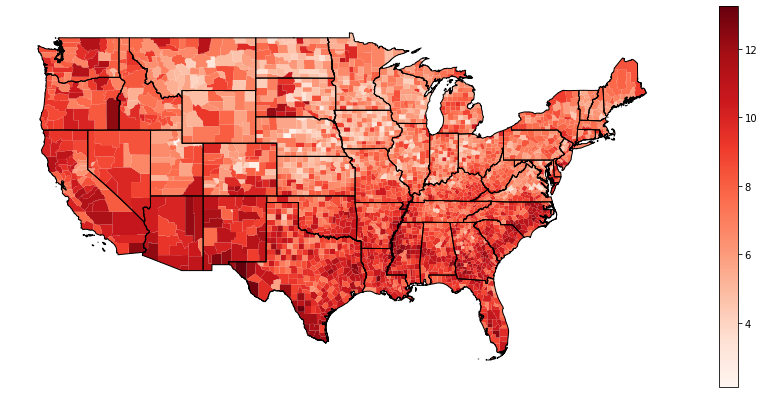

In [9]:
# Create a map of SVI with red color scheme
fig, ax = plt.subplots(figsize=(15, 7)) # Create empty canvas
svi_conus.plot(col_selected, cmap='Reds', legend=True, ax=ax) # Plot SVI 
states.boundary.plot(ax=ax, color='black', linewidth=1) # Plot state boundary
ax.set_axis_off() # remove ticks of plot
plt.show() # show plot

## Changing Coordinate Systems

Geographic Coordinate System (e.g., WGS84 or NAD83) might not be a good choice for visualizing the national-level data as it could exaggerate high-latitude areas. Here, we will change the coordinate system to Alber's equal-area conic projection, the recommended projected coordinate system for CONUS. 

In [10]:
# The original coordinate system (crs)
svi_conus.crs

<Geographic 2D CRS: EPSG:4269>
Name: NAD83
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: North America - onshore and offshore: Canada - Alberta; British Columbia; Manitoba; New Brunswick; Newfoundland and Labrador; Northwest Territories; Nova Scotia; Nunavut; Ontario; Prince Edward Island; Quebec; Saskatchewan; Yukon. Puerto Rico. United States (USA) - Alabama; Alaska; Arizona; Arkansas; California; Colorado; Connecticut; Delaware; Florida; Georgia; Hawaii; Idaho; Illinois; Indiana; Iowa; Kansas; Kentucky; Louisiana; Maine; Maryland; Massachusetts; Michigan; Minnesota; Mississippi; Missouri; Montana; Nebraska; Nevada; New Hampshire; New Jersey; New Mexico; New York; North Carolina; North Dakota; Ohio; Oklahoma; Oregon; Pennsylvania; Rhode Island; South Carolina; South Dakota; Tennessee; Texas; Utah; Vermont; Virginia; Washington; West Virginia; Wisconsin; Wyoming. US Virgin Islands. British Virgin Islands

In [11]:
# Change the coordinate system of GeoDataFrame into Albers equal-area conic projection
svi_conus = svi_conus.to_crs(epsg=5070)
states = states.to_crs(epsg=5070)

In [12]:
# Changed coordinate system (crs)
svi_conus.crs

<Derived Projected CRS: EPSG:5070>
Name: NAD83 / Conus Albers
Axis Info [cartesian]:
- X[east]: Easting (metre)
- Y[north]: Northing (metre)
Area of Use:
- name: United States (USA) - CONUS onshore - Alabama; Arizona; Arkansas; California; Colorado; Connecticut; Delaware; Florida; Georgia; Idaho; Illinois; Indiana; Iowa; Kansas; Kentucky; Louisiana; Maine; Maryland; Massachusetts; Michigan; Minnesota; Mississippi; Missouri; Montana; Nebraska; Nevada; New Hampshire; New Jersey; New Mexico; New York; North Carolina; North Dakota; Ohio; Oklahoma; Oregon; Pennsylvania; Rhode Island; South Carolina; South Dakota; Tennessee; Texas; Utah; Vermont; Virginia; Washington; West Virginia; Wisconsin; Wyoming.
- bounds: (-124.79, 24.41, -66.91, 49.38)
Coordinate Operation:
- name: Conus Albers
- method: Albers Equal Area
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

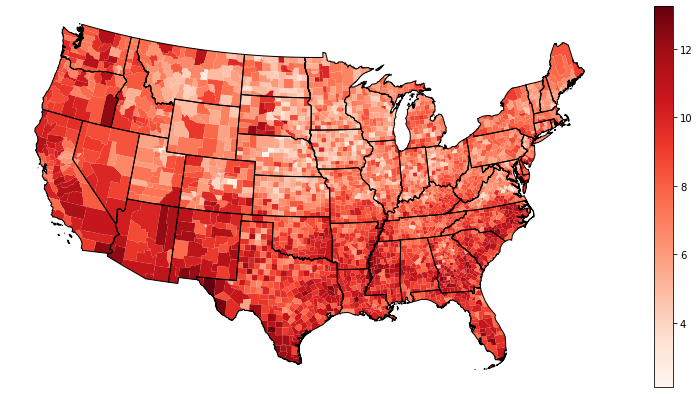

In [13]:
# Create a map of SVI with red color scheme
fig, ax = plt.subplots(figsize=(15, 7)) # Create empty canvas
svi_conus.plot(col_selected, cmap='Reds', legend=True, ax=ax) # Plot SVI 
states.boundary.plot(ax=ax, color='black', linewidth=1) # Plot state boundary
ax.set_axis_off() # remove ticks of plot
plt.show() # show plot

## Various Choropleth maps with different classification methods

We will examine how the maps will be different based on the following classificaiton methods. 
- **Equal Interval** divides the classes with equal interval.
- **Quantiles** has the same count of features in each class.
- **Standard Deviation** makes each standard deviation becomes a class (e.g., -2 std, -1 std, 1 std, and 2 std).
- **Natural Breaks** creates classes with maximum inter-class deviation with minimum intra-class deviation, (optimistically speaking).

<AxesSubplot:>

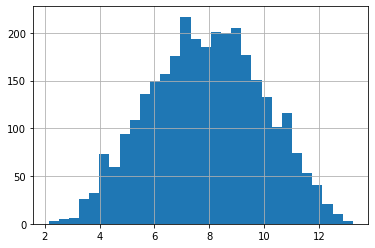

In [14]:
# Distribution of the data
svi_conus[col_selected].hist(bins=30)

In [15]:
# Simple statistics of the data
svi_conus[col_selected].describe()

count    3108.000000
mean        7.901143
std         2.049767
min         2.136000
25%         6.414000
50%         7.939350
75%         9.383075
max        13.245600
Name: SPL_THEMES, dtype: float64

---
### *Exercise* (3 minutes)
### Choose your own color scheme for Choropleth maps

Color scheme has a huge influence on the interpretation of maps. Here, we will try to stay away from the color scheme provided by `matplotlib` package and use our own color scheme. 

Please visit the website below and copy and paste the color scheme you like the most. 
1. Visit https://colorbrewer2.org/.
2. Select `sequential` among the three radio buttons on the top-left corner (It is selected by default). 
3. Change `Number of data classes` to `5`, and pick the color you like the most. 
4. Expand `EXPORT` button.
5. Copy and paste the hex color codes under `JavaScript` into `input_colors` in the cell below. 

---

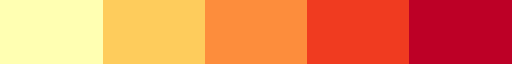

In [16]:
# Define our own color scheme
input_colors = ['#ffffb2','#fecc5c','#fd8d3c','#f03b20','#bd0026']
my_color_bar = LinearSegmentedColormap.from_list('my_color_bar', input_colors, N=5)
my_color_bar

### Choropleth map with Equal Interval Classification

This method divides the classes with equal intervals.

In [17]:
# Conduct map classificaiton 
cls_ei5 = mapclassify.EqualInterval( # Classification method
                                    svi_conus[col_selected], # Column to be used for classification
                                   )
cls_ei5

EqualInterval         

   Interval      Count
----------------------
[ 2.14,  4.36] |   145
( 4.36,  6.58] |   705
( 6.58,  8.80] |  1173
( 8.80, 11.02] |   883
(11.02, 13.25] |   202

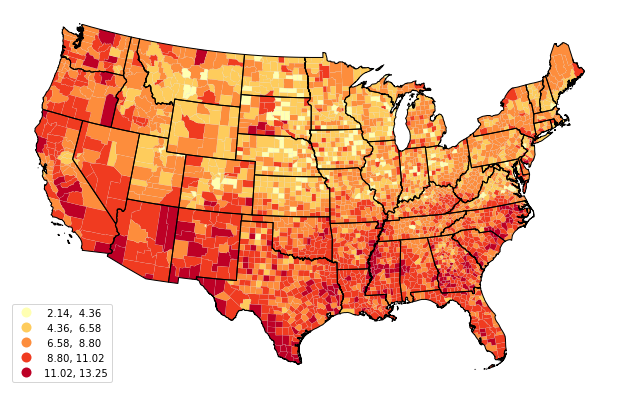

In [18]:
fig, ax = plt.subplots(figsize=(15, 7)) # Create an empty canvas

# Plot a map
cls_ei5.plot(gdf=svi_conus, # GeoDataFrame that will be used for plotting
             cmap=my_color_bar, # Color bar, which was defined above
             legend=True, # Will show the associate legend
             legend_kwds={'loc': 'lower left'},  # Location of legend
             ax=ax  # Destination of the plot
            )

# Supplementary for visualization purposes
states.boundary.plot(ax=ax, color='black', linewidth=1) # Plot boundary of states
ax.set_axis_off() # Hide ticks of the plot
plt.show() # Show plot

---
### *Challenges* (5 minutes)
### Choose your own classifications for Choropleth maps

In this challenge, you will create **three maps** with **1) [Quantiles](https://pysal.org/mapclassify/generated/mapclassify.Quantiles.html#mapclassify.Quantiles), 2) [Standard Deviation](https://pysal.org/mapclassify/generated/mapclassify.StdMean.html#mapclassify.StdMean), and 3) [Natural Breaks](https://pysal.org/mapclassify/generated/mapclassify.NaturalBreaks.html#mapclassify.NaturalBreaks)**.<br> 
1. Please visit [`mapclassify`](https://pysal.org/mapclassify/api.html) API website and find corresponding function.
2. Create three empty cells below (one for each method).
3. Copy and paste the following skeleton code into the cells. 
4. Modify the code as needed. 
***HINT***: YOU ONLY NEED TO REPLACE A VARIABLE, where indicated by `REPLACE_HERE`. 

```python
# Conduct map classificaiton 
temp_class = mapclassify.***REPLACE_HERE***( # Classification method
                                            svi_conus[col_selected], # Column to be used for classification
                                           )

fig, ax = plt.subplots(figsize=(15, 7)) # Create an empty canvas
# Plot a map
temp_class.plot(gdf=svi_conus, # GeoDataFrame that will be used for plotting
                cmap=my_color_bar, # Color bar, which was defined above
                legend=True, # Will show the associate legend
                legend_kwds={'loc': 'lower left'},  # Location of legend
                ax=ax  # Destination of the plot
                )

# Supplementary for visualization purposes
states.boundary.plot(ax=ax, color='black', linewidth=1) # Plot boundary of states
ax.set_axis_off() # Hide ticks of the plot
plt.show() # Show plot
```


### Choropleth map with Quantiles

Please uncomment the code below and replace `REPLACE_HERE` with associated function [(Quantiles)](https://pysal.org/mapclassify/generated/mapclassify.Quantiles.html#mapclassify.Quantiles). <br>
To uncomment the code,
1. Select the entire code in the cell.
2. Use shortcut (Ctrl+/) to uncomment the code. 


In [19]:
# cls_q5 = mapclassify.REPLACE_HERE(svi_conus[col_selected])

# fig, ax = plt.subplots(figsize=(15, 7)) # Create an empty canvas

# # Plot a map
# cls_q5.plot(gdf=svi_conus, # GeoDataFrame that will be used for plotting
#              cmap=my_color_bar, # Color bar, which was defined above
#              legend=True, # Will show the associate legend
#              legend_kwds={'loc': 'lower left'},  # Location of legend
#              ax=ax  # Destination of the plot
#             )

# # Supplementary for visualization purposes
# states.boundary.plot(ax=ax, color='black', linewidth=1) # Plot boundary of states
# ax.set_axis_off() # Hide ticks of the plot
# plt.show() # Show plot

### Choropleth map with Standard Deviation

Please uncomment the code below and replace `REPLACE_HERE` with associated function [(StdMean)](https://pysal.org/mapclassify/generated/mapclassify.StdMean.html#mapclassify.StdMean). <br>
To uncomment the code,
1. Select the entire code in the cell.
2. Use shortcut (Ctrl+/) to uncomment the code. 

In [20]:
# cls_sm5 = mapclassify.REPLACE_HERE(svi_conus[col_selected])

# fig, ax = plt.subplots(figsize=(15, 7)) # Create an empty canvas

# # Plot a map
# cls_sm5.plot(gdf=svi_conus, # GeoDataFrame that will be used for plotting
#              cmap=my_color_bar, # Color bar, which was defined above
#              legend=True, # Will show the associate legend
#              legend_kwds={'loc': 'lower left'},  # Location of legend
#              ax=ax  # Destination of the plot
#             )

# # Supplementary for visualization purposes
# states.boundary.plot(ax=ax, color='black', linewidth=1) # Plot boundary of states
# ax.set_axis_off() # Hide ticks of the plot
# plt.show() # Show plot

### Choropleth map with Natural Breaks

Please uncomment the code below and replace `REPLACE_HERE` with associated function [(NaturalBreaks)](https://pysal.org/mapclassify/generated/mapclassify.NaturalBreaks.html#mapclassify.NaturalBreaks). <br>
To uncomment the code,
1. Select the entire code in the cell.
2. Use shortcut (Ctrl+/) to uncomment the code. 

In [21]:
# cls_nb5 = mapclassify.REPLACE_HERE(svi_conus[col_selected])

# # Plot a map
# cls_nb5.plot(gdf=svi_conus, # GeoDataFrame that will be used for plotting
#              cmap=my_color_bar, # Color bar, which was defined above
#              legend=True, # Will show the associate legend
#              legend_kwds={'loc': 'lower left'},  # Location of legend
#              ax=ax  # Destination of the plot
#             )

# # Supplementary for visualization purposes
# states.boundary.plot(ax=ax, color='black', linewidth=1) # Plot boundary of states
# ax.set_axis_off() # Hide ticks of the plot
# plt.show() # Show plot

### Compare maps

In [22]:
cls_q5 = mapclassify.Quantiles(svi_conus[col_selected])
cls_sm5 = mapclassify.StdMean(svi_conus[col_selected])
cls_nb5 = mapclassify.NaturalBreaks(svi_conus[col_selected])

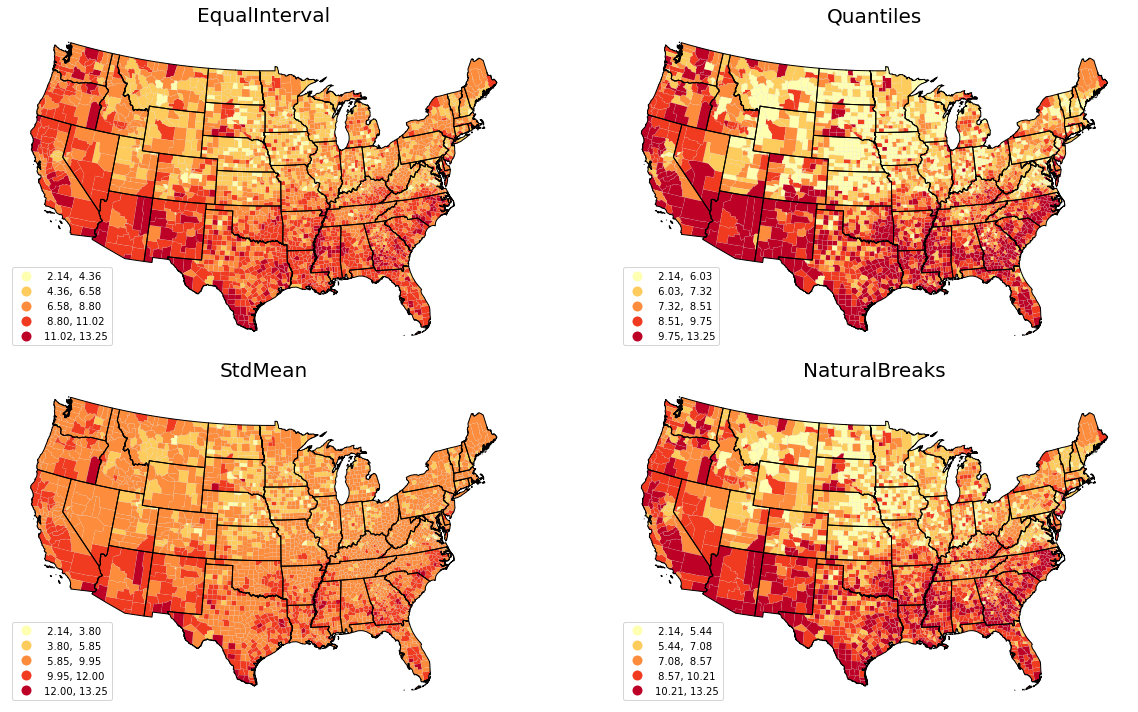

In [23]:
fig, axes = plt.subplots(2,2, figsize=(18, 10))
axes = axes.reshape(-1)

class_methods = [cls_ei5, cls_q5, cls_sm5, cls_nb5]
for idx, temp_method in enumerate(class_methods):
    temp_method.plot(gdf=svi_conus, 
                     cmap= my_color_bar, 
                     legend=True,
                     legend_kwds={'loc': 'lower left'},
                     ax=axes[idx]
                    )
    states.boundary.plot(ax=axes[idx], color='black', linewidth=1)
    axes[idx].set_title(temp_method.name, fontsize=20)
    axes[idx].set_axis_off()
    
plt.tight_layout()
plt.show()

### So, what's the best classification method? 

While it can vary depending on the situation, the best method is considered as the one which can maximize inter-class deviation and minimize intra-class deviation. <br>
The code below calculates **Absolute deviation around class median (ADCM)**, and the method with minimum value can be considered the best one. 

<AxesSubplot:ylabel='name'>

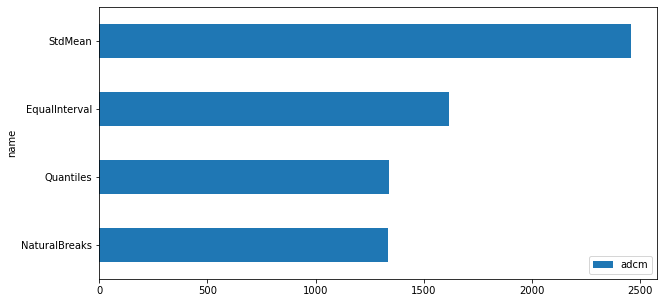

In [24]:
class_result = pd.DataFrame({'adcm': [c.adcm for c in class_methods],
                             'name': [c.name for c in class_methods]})
class_result.sort_values('adcm', inplace=True)
class_result.plot.barh('name', 'adcm', figsize=(10,5))

## Spatial Autocorrelation

Now, we will exmaine spatial autocorrelation of SVI with Moran's I and Local Indicator of Spatial Association (LISA). 

Global **Moran's I** demonstrates how geographical phenomena are correlated over space, meaning whether closer things is more related than distant things. The method provides an index with the range -1 to 1; namely, -1 is a strong negative spatial autocorrelation and 1 is a strong positive spatial autocorrelation.
<br><br>
While Global Moran's I only provides one index to demonstrate spatial autocorrelation, **Local Indicator of Spatial Association (LISA)**, as known as Local Moran's I explains where high (i.e., HH Cluster) and low (LL Cluster) values are clustered.

In [25]:
w = libpysal.weights.Queen.from_dataframe(svi_conus) # Calculate spatial relationship (contiguity) of geometry
y = svi_conus[col_selected] # Value to be used for spatial autocorrelation

The following figure will demonstrate what **contiguity** means. Here, we use Queen's case. 

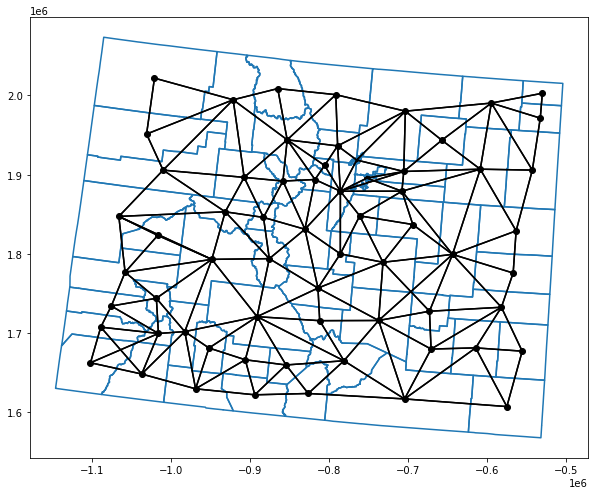

In [26]:
svi_co = svi_conus.loc[svi_conus['ST_ABBR'] == 'CO'].reset_index(drop=True) # Select counties in Colorado
w_co = libpysal.weights.Queen.from_dataframe(svi_co)

fig, ax = plt.subplots(figsize=(10,10)) # Create an empty canvas

w_co.plot(svi_co, ax=ax)
svi_co.boundary.plot(ax=ax)
plt.show()

### Calculating Moran's I

In [27]:
mi_svi = esda.moran.Moran(y, w)

print(f"Moran's I is {round(mi_svi.I, 3)} with p-value {round(mi_svi.p_norm, 5)}, meaning they are highly spatially autocorrelated.")

('WARNING: ', 1186, ' is an island (no neighbors)')
('WARNING: ', 1192, ' is an island (no neighbors)')
('WARNING: ', 2946, ' is an island (no neighbors)')
Moran's I is 0.529 with p-value 0.0, meaning they are highly spatially autocorrelated.


### Calculating LISA

In [28]:
# Remove counties without adjacent county
svi_conus_ = svi_conus.loc[~svi_conus.index.isin(w.islands)].reset_index(drop=True)

w_lisa = libpysal.weights.Queen.from_dataframe(svi_conus_)  # Calculate spatial relationship (contiguity) of geometry
y_lisa = svi_conus_[col_selected] # Value to be used for spatial autocorrelation

# Calculate LISA
lm_svi = esda.moran.Moran_Local(y_lisa, w_lisa, seed=17)

In [29]:
# Classes of LISA
lisa_dict = {1: 'HH', 2:'LH', 3:'LL', 4:'HL'} 
# Color for LISA clusters
lisa_color = {'HH': '#FF0000', # Red
              'LH': '#FFCCCB', # Light red
              'LL': '#0000FF', # Blue
              'HL': '#ADD8E6', # Light blue
              'NA': '#FFFFFF'  # Light grey
             } 

for idx in range(len(lm_svi.y)):
    temp_q = lm_svi.q[idx] # Select a cluster of each row
    temp_pval = lm_svi.p_z_sim[idx] # Select p-value of each row
    
    if temp_pval < 0.05: # if the p-value is statistically significant (p-value < 0.05)
        svi_conus_.at[idx, 'LISA'] = lisa_dict[temp_q] # Will define local cluster
    else:
        svi_conus_.at[idx, 'LISA'] = 'NA' # If not significant, NA
        
svi_conus_['color'] = svi_conus_.apply(lambda x:lisa_color[x['LISA']], axis=1) # Assign color per LISA cluster
svi_conus_


ST    STATE ST_ABBR      COUNTY   FIPS  SPL_THEMES  \
0     01  Alabama      AL     Autauga  01001      8.0255   
1     01  Alabama      AL     Baldwin  01003      6.8498   
2     01  Alabama      AL     Barbour  01005     12.2801   
3     01  Alabama      AL        Bibb  01007      9.8077   
4     01  Alabama      AL      Blount  01009      8.0278   
...   ..      ...     ...         ...    ...         ...   
3100  56  Wyoming      WY  Sweetwater  56037      7.1912   
3101  56  Wyoming      WY       Teton  56039      5.9720   
3102  56  Wyoming      WY       Uinta  56041      7.3769   
3103  56  Wyoming      WY    Washakie  56043      6.5491   
3104  56  Wyoming      WY      Weston  56045      6.2839   

                                               geometry  ContiguousUS LISA  \
0     POLYGON ((845502.651 1105502.561, 845570.149 1...             1   HH   
1     POLYGON ((765297.991 826660.876, 765703.766 82...             1   LH   
2     POLYGON ((966818.148 1001565.672, 967065.502 1...             1   HH   
3     POLYGON ((795521.328 1139598.901, 805055.230 1...             1   NA   
4     POLYGON ((828860.688 1238570.568, 829200.834 1...             1   NA   
...                                                 ...           ...  ...   
3100  POLYGON ((-1151809.623 2197471.894, -1151753.9...             1   LL   
3101  POLYGON ((-1186278.535 2502721.673, -1162597.8...             1   LL   
3102  POLYGON ((-1247555.219 2115432.000, -1246760.5...             1   LL   
3103  POLYGON ((-997846.866 2417231.150, -997597.050...             1   NA   
3104  POLYGON ((-724949.677 2365214.220, -722597.332...             1   NA   

        color  
0     #FF0000  
1     #FFCCCB  
2     #FF0000  
3     #FFFFFF  
4     #FFFFFF  
...       ...  
3100  #0000FF  
3101  #0000FF  
3102  #0000FF  
3103  #FFFFFF  
3104  #FFFFFF  

[3105 rows x 10 columns]

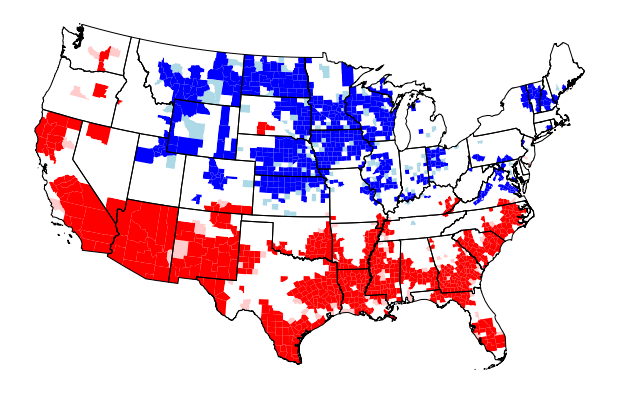

In [30]:
fig, ax = plt.subplots(figsize=(15, 7)) # Create an empty canvas

svi_conus_.plot('LISA', color=svi_conus_['color'], ax=ax, legend=True) # Plot LISA result

# Supplementary for visualization purposes
states.boundary.plot(ax=ax, color='black', linewidth=1) # Plot boundary of states
ax.set_axis_off() # Hide ticks of the plot
plt.show() # Show plot

### Interactive map

You can also examine LISA of a specific county with the code below. 

In [ ]:
svi_conus_.explore(color='color', style_kwds={'weight':0.5, 'color':'black'})

# Done